
# Fig 1D

Conexiones listas. Tiempo de setup: 0.002752065658569336 s
Simulación terminada.


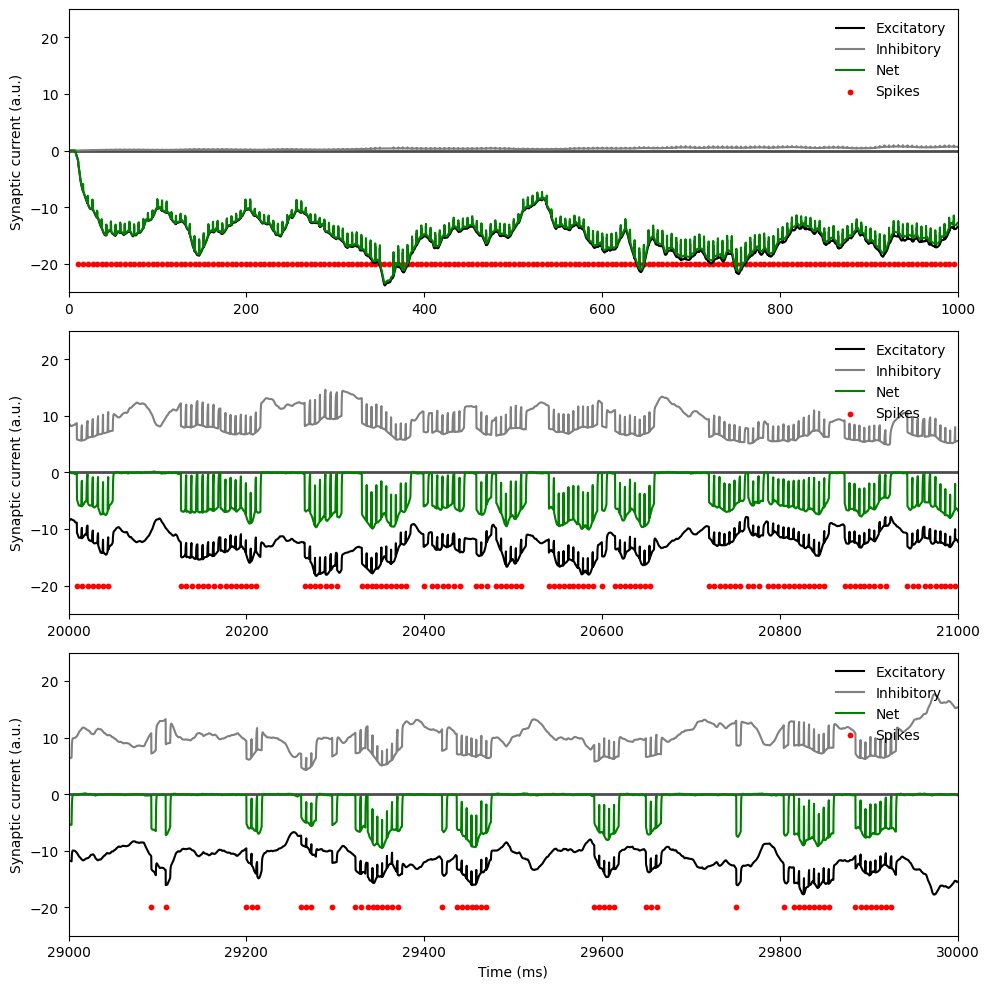

In [ ]:
import nest
import matplotlib.pyplot as plt
import numpy as np
import time

# ==================== RESET NEST ====================
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({
    "resolution": resolution,   
    "print_time": True
})
np.random.seed(42)

# ==================== PARÁMETROS DEL MODELO ====================
neuron_params = {
    "C_m": 200.0,        # pF
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

tau_ex = 5.0    # ms
tau_in = 10.0   # ms

# ==================== CREAR NEURONA POSTSINÁPTICA ====================
post = nest.Create("iaf_cond_alpha", params={
    **neuron_params, 
    "tau_syn_ex": tau_ex, 
    "tau_syn_in": tau_in
})

# ==================== CONFIGURACIÓN DE GRUPOS ====================
n_groups = 8                    
N_exc_per_group = 100           
N_inh_per_group = 25           

exc_parrots = []
inh_parrots = []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc_per_group))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh_per_group))

# ==================== GENERAR SEÑALES MODULADAS ====================
T_sim = 30000.0  # ms
dt_signal = 5.0  # ms
tau_signal = 50.0  # ms
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0  # Hz
rate_std = 5.0    # Hz

signals = []
for g in range(n_groups):
    noise = np.random.randn(len(times))
    signal = np.zeros_like(noise)
    for i in range(1, len(signal)):
        signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])
    signal = (signal - np.mean(signal)) / np.std(signal)
    rates = rate_mean + rate_std * signal
    rates[rates < 0.1] = 0.1
    signals.append(rates)

# ==================== PESOS EXCITATORIOS ====================
preferred_group = 4
w_exc_max = 3.0
w_exc_min = 1.5

w_exc_by_group = []
for g in range(n_groups):
    if g == preferred_group:
        w_exc_by_group.append(w_exc_max)
    else:
        distance = abs(g - preferred_group)
        weight = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-distance/2.0)
        w_exc_by_group.append(weight)

# ==================== GENERADORES DE POISSON ====================
exc_gens = []
inh_gens = []

for g in range(n_groups):
    exc_gen = nest.Create("inhomogeneous_poisson_generator", params={
        "rate_times": times.tolist(),
        "rate_values": signals[g].tolist(),
        "origin": 0.0,
        "start": 0.0
    })
    inh_gen = nest.Create("inhomogeneous_poisson_generator", params={
        "rate_times": times.tolist(),
        "rate_values": signals[g].tolist(),
        "origin": 0.0,
        "start": 0.0
    })
    exc_gens.append(exc_gen)
    inh_gens.append(inh_gen)

# ==================== PARÁMETROS DE SINAPSIS ====================
delay = 1.0

inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,
    "delay": delay,
    "eta": 0.005,
    "alpha": 0.0025,
    "tau": 20.0,
    "Wmax": -200.0,
}

# ==================== CONEXIONES ====================
start_time = time.time()

for g in range(n_groups):
    nest.Connect(exc_gens[g], exc_parrots[g], conn_spec="all_to_all")
    nest.Connect(inh_gens[g], inh_parrots[g], conn_spec="all_to_all")
    nest.Connect(
        exc_parrots[g], post,
        syn_spec={
            "synapse_model": "static_synapse",
            "weight": w_exc_by_group[g],
            "delay": delay,
        })
    nest.Connect(
        inh_parrots[g], post,
        syn_spec=inh_syn_params
    )

# ==================== MULTIMETER ====================
multimeter = nest.Create("multimeter", params={
    "record_from": ["V_m", "g_ex", "g_in"],
    "interval": 0.1
})
nest.Connect(multimeter, post)

# ==================== SPIKE RECORDER ====================
spike_recorder = nest.Create("spike_recorder")
nest.Connect(post, spike_recorder)

# ==================== SIMULACIÓN ====================
nest.Simulate(T_sim)

# ==================== DATOS DEL MULTIMETER ====================
events = nest.GetStatus(multimeter, "events")[0]
t = events["times"]
V = events["V_m"]
gE = events["g_ex"]
gI = events["g_in"]

E_ex = neuron_params["E_ex"]
E_in = neuron_params["E_in"]

I_E = gE * (-E_ex + V)
I_I = gI * (- E_in + V)
I_net = I_E + I_I

# ==================== DATOS DE SPIKES ====================
spike_events = nest.GetStatus(spike_recorder, "events")[0]
spike_times = spike_events["times"]

# ==================== INTERVALOS ====================
intervalos = [
    (0, 1000),
    (20000, 21000),
    (29000, 30000)
]

# ==================== GRAFICAR SUBPLOTS ====================
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

for ax, (inicio, fin) in zip(axs, intervalos):
    ax.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    # Filtrar datos del multimeter para este intervalo
    mask = (t >= inicio) & (t <= fin)
    ax.plot(t[mask], I_E[mask]/1000, color="black", label="Excitatory")
    ax.plot(t[mask], I_I[mask]/1000, color="gray", label="Inhibitory")
    ax.plot(t[mask], I_net[mask]/1000, color="green", label="Net")
    
    # Filtrar spikes para este intervalo
    spike_mask = (spike_times >= inicio) & (spike_times <= fin)
    y_offset = -20 # ajustar según tus límites de y
    ax.scatter(spike_times[spike_mask], np.full_like(spike_times[spike_mask], y_offset), 
           color="red", s=10, label="Spikes")
    ax.set_xlim(inicio, fin)
    ax.set_ylim(-25,25)
    ax.set_ylabel("Synaptic current (a.u.)")
    ax.legend(frameon=False, loc="upper right")

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


# Fig 1E (Evoked canals)

In [16]:
import nest
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ======================================================
# PARÁMETROS EXACTOS
# ======================================================

nest.ResetKernel()
resolution = 0.1  # dt = 0.1 ms
nest.SetKernelStatus({"resolution": resolution})
np.random.seed(42)

n_groups = 8
N_exc = 100
N_inh = 25

# Tiempos
T_learn = 300000.0   # 10 minutos (con eta=1e-4 necesitas más)
T_measure = 4000.0

dt = 0.1  # ms (simulation timestep)
# ======================================================
# GENERACIÓN DE SEÑALES - MÉTODO EXACTO DEL PAPER
# ======================================================

def generate_signal_exact_paper(duration_ms, dt_ms=0.1, tau_ms=50.0, 
                                sparsify=True, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    n_steps = int(duration_ms / dt_ms)
    
    # 1. Generar señal con filtro low-pass
    s_raw = np.zeros(n_steps)
    
    for i in range(1, n_steps):
        # ξ ~ Uniform[-0.5, 0.5]
        xi = np.random.uniform(-0.5, 0.5)
        # s(t+dt) = ξ - (ξ - s(t)) × exp(-dt/τ)
        s_raw[i] = xi - (xi - s_raw[i-1]) * np.exp(-dt_ms / tau_ms)
    
    # 2. Half-wave rectification
    s_rect = s_raw.copy()
    s_rect[s_rect < 0] = 0
    
    # 3. Normalización a peak = 500 Hz × dt = 0.05
    peak_target = 500.0 * (dt_ms / 1000.0)  # 500 Hz × dt
    if np.max(s_rect) > 0:
        s_norm = s_rect * (peak_target / np.max(s_rect))
    else:
        s_norm = s_rect
    
    # 4. Sparsificación (eliminar ~50% de bumps)
    if sparsify:
        s_sparse = sparsify_signal(s_norm, dt_ms)
    else:
        s_sparse = s_norm
    
    # 5. Añadir baseline constante
    baseline = 5.0 * (dt_ms / 1000.0)  # 5 Hz × dt = 0.0005
    s_final = s_sparse + baseline
    
    return s_final

def sparsify_signal(signal, dt_ms, threshold_factor=0.3):

    
    # Detectar bumps (regiones por encima del threshold)
    threshold = np.mean(signal[signal > 0]) * threshold_factor
    above_threshold = signal > threshold
    
    # Encontrar inicio y fin de cada bump
    bump_starts = np.where(np.diff(above_threshold.astype(int)) == 1)[0]
    bump_ends = np.where(np.diff(above_threshold.astype(int)) == -1)[0]
    
    # Asegurar que tengan el mismo tamaño
    n_bumps = min(len(bump_starts), len(bump_ends))
    bump_starts = bump_starts[:n_bumps]
    bump_ends = bump_ends[:n_bumps]
    
    # Eliminar aleatoriamente ~50% de los bumps
    s_sparse = signal.copy()
    n_to_remove = n_bumps // 2
    bumps_to_remove = np.random.choice(n_bumps, n_to_remove, replace=False)
    
    for idx in bumps_to_remove:
        start = bump_starts[idx]
        end = bump_ends[idx]
        s_sparse[start:end+1] = 0
    
    return s_sparse

# ======================================================
# GENERAR 8 SEÑALES
# ======================================================

# Para el aprendizaje, generar señales largas
signals_prob = []  # Probabilidades de spike (no rates!)

for k in range(n_groups):
    s = generate_signal_exact_paper(T_learn, dt_ms=dt, sparsify=True, seed=42+k)
    signals_prob.append(s)
    
    # Estadísticas
    mean_prob = np.mean(s)
    mean_rate = mean_prob / (dt / 1000.0)  # Convertir prob → rate
    max_prob = np.max(s)
    max_rate = max_prob / (dt / 1000.0)
    
    print(f"  Señal {k+1}: mean_rate={mean_rate:.1f} Hz, "
          f"peak_rate={max_rate:.1f} Hz, "
          f"prob_range=[{np.min(s):.6f}, {np.max(s):.6f}]")

# ======================================================
# CONFIGURACIÓN RED
# ======================================================

neuron_params = {
    "C_m": 200.0,
    "g_L": 10.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "t_ref": 5.0,
    "E_ex": 0.0,
    "E_in": -80.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0
}

post = nest.Create("iaf_cond_alpha", params=neuron_params)

exc_parrots, inh_parrots = [], []
for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh))

# ======================================================
# PESOS EXCITATORIOS - FUNCIÓN EXACTA DEL PAPER
# ======================================================

# Parámetros del paper
delta_gE = 140.0  # pS (¡NO nS!)
P = 5  # Canal preferido (posición del pico)

# Función de tuning: W_ij = 0.3 + 1.1 / (1 + (K(j) - P)^4) + ε
# donde K ∈ {1...8} es el canal

w_exc = []
epsilon = 0.0  # Pequeño ruido (opcional)

for K in range(1, n_groups + 1):
    W = 0.3 + 1.1 / (1.0 + (K - P)**4) + epsilon
    # Peso final en nS
    weight_nS = (delta_gE / 1000.0) * W  # 140 pS → 0.14 nS × W
    w_exc.append(weight_nS)

print("\nPesos excitatorios (nS):")
for k in range(n_groups):
    marker = " ← PREFERIDO" if k == (P-1) else ""
    print(f"  Canal {k+1}: {w_exc[k]:.4f} nS{marker}")

# ======================================================
# GENERADORES - CON PROBABILIDADES
# ======================================================

delay = 1.0

# Convertir probabilidades a rates para inhomogeneous_poisson_generator
# Rate (Hz) = Probability / dt (s)
times = np.arange(dt, T_learn + dt, dt)

for g in range(n_groups):
    # Convertir probabilidad → rate
    # La probabilidad ya incluye dt, así que:
    # rate (Hz) = prob / (dt/1000)
    rates = signals_prob[g] / (dt / 1000.0)
    
    # Para cada spike train independiente
    for n in range(N_exc):
        gen = nest.Create(
            "inhomogeneous_poisson_generator",
            params={
                "rate_times": times.tolist(),
                "rate_values": rates.tolist()
            }
        )
        nest.Connect(gen, exc_parrots[g][n])
    
    for n in range(N_inh):
        gen = nest.Create(
            "inhomogeneous_poisson_generator",
            params={
                "rate_times": times.tolist(),
                "rate_values": rates.tolist()
            }
        )
        nest.Connect(gen, inh_parrots[g][n])


# ======================================================
# PARÁMETROS DE PLASTICIDAD
# ======================================================
eta_paper = 1e-3 #(x2 paper)
alpha_paper = 0.2
target_rate = 5.0

inh_plastic = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,
    "delay": delay,
    "eta": eta_paper,
    "alpha": alpha_paper,
    "tau": 20.0,
    "Wmax": -500.0
}


# Conectar
for g in range(n_groups):
    nest.Connect(exc_parrots[g], post,
                 syn_spec={"weight": w_exc[g], "delay": delay})
    nest.Connect(inh_parrots[g], post, syn_spec=inh_plastic)
# =====================================================
# APRENDIZAJE
# ======================================================
spike_det = nest.Create("spike_recorder")
nest.Connect(post, spike_det)

monitoring_interval = 30000.0  # 30 segundos
n_steps = int(T_learn / monitoring_interval)

weight_history = []
rate_history = []
time_history = []

for step in range(n_steps):
    nest.Simulate(monitoring_interval)
    current_time = (step + 1) * monitoring_interval
    
    # Firing rate
    spikes = spike_det.get("events")["times"]
    recent = spikes[spikes > current_time - monitoring_interval]
    rate = len(recent) / (monitoring_interval / 1000.0)
    
    # Pesos
    conns = nest.GetConnections(target=post,
                                synapse_model="vogels_sprekeler_synapse")
    weights = np.array(conns.get("weight"))
    mean_w = np.mean(np.abs(weights))
    
    time_history.append(current_time / 1000.0)
    rate_history.append(rate)
    weight_history.append(mean_w)
    
    # Imprimir cada 2 minutos
    if (step + 1) % 4 == 0:
        print(f"  {current_time/60000:5.1f} min | rate={rate:5.2f} Hz | w_mean={mean_w:6.2f} nS")


# ======================================================
# PESOS APRENDIDOS
# ======================================================
conns = nest.GetConnections(target=post,
                            synapse_model="vogels_sprekeler_synapse")
weights = np.array(conns.get("weight"))
w_inh_frozen = np.split(weights, n_groups)
w_inh_mean = [np.mean(w) for w in w_inh_frozen]


for g in range(n_groups):
    ratio = abs(w_inh_mean[g]) / w_exc[g]
    marker = " ← PREF" if g == (P-1) else ""
    print(f"  {g+1}   |  {w_exc[g]:.4f}  | {w_inh_mean[g]:7.2f} | {ratio:6.2f}{marker}")

# ======================================================
# MEDICIÓN FIG 1E
# ======================================================

nest.ResetKernel()
nest.SetKernelStatus({"resolution": resolution})

# Generar señales para medición
signals_measure = []
times_measure = np.arange(dt, T_measure + dt, dt)

for k in range(n_groups):
    s = generate_signal_exact_paper(T_measure, dt_ms=dt, sparsify=True, seed=42+k)
    signals_measure.append(s)

post_neurons = []
multimeters = []

for g in range(n_groups):
    post_g = nest.Create("iaf_cond_alpha", params=neuron_params)
    post_neurons.append(post_g)
    
    mm = nest.Create(
        "multimeter",
        params={
            "record_from": ["V_m", "g_ex", "g_in"],
            "interval": resolution
        }
    )
    nest.Connect(mm, post_g)
    multimeters.append(mm)
    
    exc_parrots_m = nest.Create("parrot_neuron", N_exc)
    inh_parrots_m = nest.Create("parrot_neuron", N_inh)
    
    nest.Connect(exc_parrots_m, post_g,
                syn_spec={"weight": w_exc[g], "delay": delay})
    nest.Connect(inh_parrots_m, post_g,
                syn_spec={"weight": w_inh_mean[g], "delay": delay})
    
    # Convertir probabilidades a rates
    rates = signals_measure[g] / (dt / 1000.0)
    
    for n in range(N_exc):
        gen = nest.Create(
            "inhomogeneous_poisson_generator",
            params={
                "rate_times": times_measure.tolist(),
                "rate_values": rates.tolist()
            }
        )
        nest.Connect(gen, exc_parrots_m[n])
    
    for n in range(N_inh):
        gen = nest.Create(
            "inhomogeneous_poisson_generator",
            params={
                "rate_times": times_measure.tolist(),
                "rate_values": rates.tolist()
            }
        )
        nest.Connect(gen, inh_parrots_m[n])

nest.Simulate(T_measure)

# Extraer corrientes
Iex = []
Iin = []
transient = 500.0

for g, mm in enumerate(multimeters):
    ev = mm.get("events")
    times_rec = ev["times"]
    V = ev["V_m"]
    gE = ev["g_ex"]
    gI = ev["g_in"]
    
    mask = times_rec > transient
    I_ex = gE[mask] * (neuron_params["E_ex"] - V[mask])
    I_in = gI[mask] * (neuron_params["E_in"] - V[mask])
    
    Iex.append(np.mean(I_ex))
    Iin.append(np.mean(I_in))
# ======================================================
# RESULTADOS FINALES
# ======================================================
# Normalización
Iex_array = np.array(Iex)
Iin_array = np.abs(np.array(Iin))
max_current = max(np.max(Iex_array), np.max(Iin_array))

Iex_norm = (Iex_array / max_current) * 100
Iin_norm = (Iin_array / max_current) * 100
balance_norm = Iex_norm - Iin_norm


for g in range(n_groups):
    if abs(balance_norm[g]) < 3:
        eval_str = "🏆 Perfecto"
    elif abs(balance_norm[g]) < 6:
        eval_str = " Excelente"
    elif abs(balance_norm[g]) < 10:
        eval_str = " Muy bueno"
    else:
        eval_str = "  Bueno"
    
    marker = " (PREF)" if g == (P-1) else ""
    print(f"  {g+1}   | {Iex_norm[g]:5.1f} | {Iin_norm[g]:5.1f} | "
          f"{balance_norm[g]:6.2f}  | {eval_str}{marker}")

balance_mean = np.mean(np.abs(balance_norm))
print(f"\nBalance promedio: {balance_mean:.2f} pA")

if balance_mean < 5:
    print(" ¡PERFECTO! Balance óptimo alcanzado")
elif balance_mean < 8:
    print(" ¡EXCELENTE! Muy cerca del óptimo")
else:
    print("  Bueno, considera más tiempo de simulación")




Jan 28 12:01:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
  Señal 1: mean_rate=31.1 Hz, peak_rate=505.0 Hz, prob_range=[0.000500, 0.050500]
  Señal 2: mean_rate=30.5 Hz, peak_rate=505.0 Hz, prob_range=[0.000500, 0.050500]
  Señal 3: mean_rate=28.8 Hz, peak_rate=443.4 Hz, prob_range=[0.000500, 0.044342]
  Señal 4: mean_rate=32.4 Hz, peak_rate=480.9 Hz, prob_range=[0.000500, 0.048094]
  Señal 5: mean_rate=29.8 Hz, peak_rate=460.2 Hz, prob_range=[0.000500, 0.046023]
  Señal 6: mean_rate=31.4 Hz, peak_rate=505.0 Hz, prob_range=[0.000500, 0.050500]
  Señal 7: mean_rate=29.8 Hz, peak_rate=469.2 Hz, prob_range=[0.000500, 0.046924]
  Señal 8: mean_rate=30.5 Hz, peak_rate=474.8 Hz, prob_range=[0.000500, 0.047475]

Pesos excitatorios (nS):
  Canal 1: 0.0426 nS
  Canal 2: 0.0439 nS
  Canal 3: 0.0511 nS
  Canal 4: 0.1190 nS
  Canal 5: 0.1960 nS ← PREFERIDO
  Canal 6: 0.1190 nS
  Canal 7: 0.0511 nS
  Canal 8: 0.0439 nS

Jan 28 12:04:16 NodeManager::

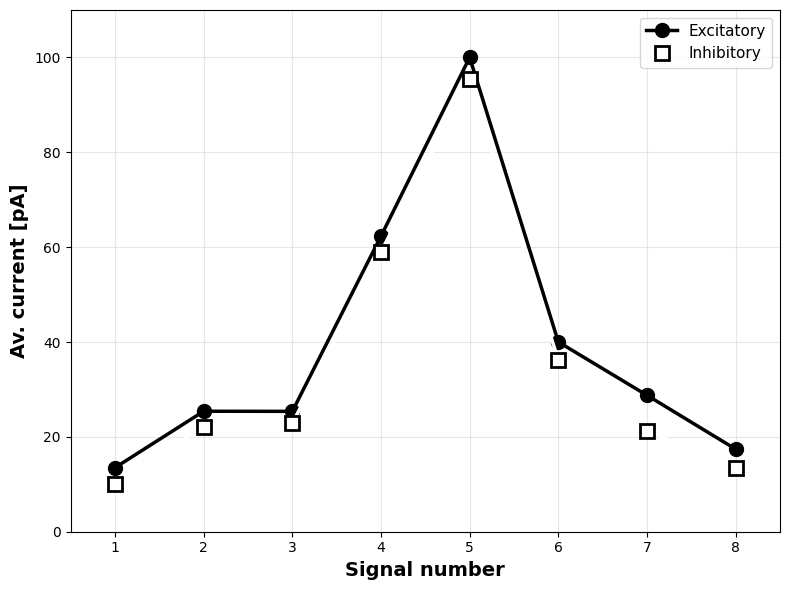

In [17]:
# ======================================================
# GRÁFICAS
# ======================================================

# Gráfica final
fig, ax = plt.subplots(figsize=(8, 6))
channels = np.arange(1, n_groups + 1)

ax.plot(channels, Iex_norm, 'o-', color='black', linewidth=2.5, 
        markersize=10, markerfacecolor='black', label='Excitatory', zorder=3)
ax.plot(channels, Iin_norm, 's-', color='white', linewidth=2.5, 
        markersize=10, markerfacecolor='white', markeredgecolor='black',
        markeredgewidth=2, label='Inhibitory', zorder=3)

ax.set_xlabel('Signal number', fontsize=14, fontweight='bold')
ax.set_ylabel('Av. current [pA]', fontsize=14, fontweight='bold')
ax.set_xticks(channels)
ax.set_xlim(0.5, n_groups + 0.5)
ax.set_ylim(0, 110)
ax.legend(loc='upper right', frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig('fig1E_exact_params.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


FIG 1E - TRES MOMENTOS (PARÁMETROS EXACTOS DEL PAPER)

Tiempo total: 5.0 minutos
Momentos: 4s, 150s, 300s

Generando señales...

Jan 28 12:27:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
✓ 8 señales generadas
Creando generadores...
